In [1]:
import os
from numpy import *
import scipy.io as sio
import scipy.interpolate as spin
from scipy import stats
import pandas as pd
import pandas.plotting._converter as pandacnv   # FIXME: only necessary due to Pandas 0.21.0 bug with Datetime plotting
pandacnv.register()                             # FIXME: only necessary due to Pandas 0.21.0 bug with Datetime plotting
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cbook as mcbook
import matplotlib.dates as mdates
import matplotlib.ticker as pltick
import matplotlib.legend as mlegend
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon, Rectangle, ConnectionPatch
if os.path.isdir('/Applications/anaconda/share/proj'): # needed for Basemap import on my machine, but probably not yours
    os.environ['PROJ_LIB'] = '/Applications/anaconda/share/proj'
from mpl_toolkits.basemap import Basemap
from matplotlib import gridspec
from datetime import datetime, timedelta
from collections import OrderedDict
from Circles.circles import circle   # from https://github.com/urschrei/Circles
import pickle
import warnings
import time
import gsw

# import custom functions
import download_product as dlp
import load_product as ldp
import time_tools as tt
import plot_tools as pt
import geo_tools as gt

In [2]:
# custom settings
set_printoptions(threshold=100)    # speeds up printing of large dicts containing NumPy arrays during debugging
plt.ion()                          # necessary for interactive contour label placement

# prettier font for plots
# note: before uncommenting, have to 'install' Helvetica using fondu (see instructions at https://goo.gl/crpbt2)
# mpl.rc('font',**{'family':'sans-serif','sans-serif':'Helvetica'})


# analyze data and generate paper figures

plot_fig_4_ED_figs_6_7 = True


# directory for plotting output
current_results_dir = os.getcwd() + '/Results/'

# directory for h4toh5 executable
script_dir = os.getcwd() + '/'

# root directory for data files
data_dir = os.getcwd() + '/Data/'

# sub-directories for data files
argo_gdac_dir = data_dir + 'Argo/'
soccom_dir = argo_gdac_dir + 'SOCCOM/'
uw_o2_dir = argo_gdac_dir + 'UW-O2/'
shipboard_dir = data_dir + 'Shipboard/'
wod_dir = shipboard_dir + 'WOD/'
waghc_dir = shipboard_dir + 'WAGHC2017/'
amsr2_dir = data_dir + 'Sea ice concentration/AMSR2/'
amsre_dir = data_dir + 'Sea ice concentration/AMSR-E/'
dmsp_nrt_dir = data_dir + 'Sea ice concentration/DMSP_NRT/'
dmsp_v3_dir = data_dir + 'Sea ice concentration/DMSP_v3/'
nimbus5_dir = data_dir + 'Sea ice concentration/Nimbus-5/'
amsr_gridfile = data_dir + 'Sea ice concentration/AMSR_grid/LongitudeLatitudeGrid-s6250-Antarctic.h5'
amsr_areafile = data_dir + 'Sea ice concentration/AMSR_grid/pss06area_v3.dat'
nsidc_ps25_grid_dir = data_dir + 'Sea ice concentration/NSIDC_polar_stereo_25km_grid/'
coastline_filename_prefix = data_dir + 'GSHHG coast shapefiles/l/GSHHS_l_L5'
climate_indices_dir = data_dir + 'Climate indices/'
reanalysis_dir = data_dir + 'Reanalysis/'
era_new_dir = data_dir + 'Reanalysis/ECMWF_Weddell_unprocessed/'
era_custom_dir = data_dir + 'Reanalysis/ECMWF_Weddell_processed/'
era_processed_gwk_moore_dir = data_dir + 'Reanalysis/ECMWF_processed_GWKMoore/'
isd_dir = data_dir + 'ISD station records/'
reader_dir = data_dir + 'READER station records/'

# sub-directories for serialized ("pickled") processed data
figure_pickle_dir = data_dir + 'Processed_pickle_archives/'
argo_index_pickle_dir = argo_gdac_dir + 'Argo_index_pickles/'

In [5]:
###################################### ANALYSIS ROUTINES ######################################################
# Fig. 4. Hydrographic observations from Maud Rise from 2011–2018.
# Extended Data Fig. 6. Full set of profiling float hydrographic observations from Maud Rise from 2011–2018.
# Extended Data Fig. 7. Heat loss during the 2016 polynya estimated from hydrographic observations.
if plot_fig_4_ED_figs_6_7:
    plot_by_depth_composite = True
    plot_by_depth = True

    [sea_ice_grids,sea_ice_data_avail,sea_ice_all_dates] = ldp.sea_ice_data_prep(nimbus5_dir,dmsp_v3_dir,dmsp_nrt_dir,
                                                                                 amsre_dir,amsr2_dir,amsr_gridfile,
                                                                                 amsr_areafile,nsidc_ps25_grid_dir)

    argo_gdac_index = pickle.load(open(argo_index_pickle_dir + 'argo_gdac_index.pickle','rb'))
    argo_soccom_index = pickle.load(open(argo_index_pickle_dir + 'argo_soccom_index.pickle','rb'))

    polynya_dates = [20160727000000,20160816000000,20170901000000,20171201000000]
    polynya_dates = [tt.convert_tuple_to_datetime(tt.convert_14_to_tuple(pd)) for pd in polynya_dates]

    wmoids = [5903616,5904468,5904471]
    toi_span = [[20160000000000,20160727000000],  # 1627 days
                [20160000000000,20180101000000],  # 1205 days, previously 1070 days
                [20160000000000,20180223000000]]  # 1279 days, previously 1269 days
#     toi_span = [[20111218000000,20160603000000],  # 1627 days
#             [20150118000000,20180509000000],  # 1205 days, previously 1070 days
#             [20141220000000,20180623000000]]  # 1279 days, previously 1269 days
    traj_plot_params = [(1.2 * 500000,220000,-65.4,1),(1.2 * 570000,500000,-65.5,3),(1.2 * 590000,500000,-65.5,2)]
    params = ['ptmp','psal','Nsquared']
    condensed_cbar_labels = ['Potential temperature\n(°C)','Salinity\n(psu)',
                             'Buoyancy frequency\nsquared ' + r'(10$^{-7}$ s$^{-2}$)']
#     width_ratios = [1627,1605,1279 * (12.0 / 9.6)]
#     height_ratios = [1650 + 175,1650,1650,1650]
    width_ratios = [1205,1705,1279 * (12.0 / 9.6)]
    height_ratios = [1650 + 175,1650,1650]
    xlabel_years_only = [True,True,True]
    show_ice_bars = True
    all_trajs = []
    float_data = []
    for f_idx,wmoid in enumerate(wmoids):
        this_float_meta = ldp.argo_gdac_float_meta(argo_gdac_index['local_prof_index'],wmoid)
        toi_mask = logical_and(this_float_meta['prof_datetimes'] >= toi_span[f_idx][0],
                               this_float_meta['prof_datetimes'] <= toi_span[f_idx][1])
        float_meta = [[wmoid,this_float_meta['prof_lons'][toi_mask],this_float_meta['prof_lats'][toi_mask],
                       this_float_meta['prof_position_flags'][toi_mask],
                       this_float_meta['prof_datetimes'][toi_mask]]]
        all_trajs.append(float_meta)
        float_data.append(ldp.argo_float_data(wmoid,argo_gdac_dir,argo_gdac_index,argo_soccom_index,
                                              prof_nums=array(this_float_meta['prof_nums'])[toi_mask],
                                              compute_extras=True,smooth_N2_PV=True,smooth_N2_PV_window=50.0))



    # full sections by depth
    if plot_by_depth:
        pt.section_compiler(wmoids,data_dir,current_results_dir,'ED_figure_6',float_data,params,figsize=(8.5,7.5),
                            depth_lim=(0,1650),mld=True,plot_title=True,sea_ice_grids=sea_ice_grids,
                            sea_ice_data_avail=sea_ice_data_avail,add_date_bars=polynya_dates,
                            condensed_cbar_labels=condensed_cbar_labels,width_ratios=width_ratios,
                            height_ratios=height_ratios,all_trajs=None,traj_plot_params=traj_plot_params,
                            show_ice_bars=show_ice_bars,density_coor=False,force_label_size=6,
                            explicit_yticks=[0,500,1000,1500],years_only=xlabel_years_only)

In [26]:
size(float_data[1]['profiles'])

71

In [27]:
# for wmoid 5904468
import numpy as np

date_raw=[]
for i in range(size(float_data[1]['profiles'])):
    date_raw.append(tt.convert_14_to_tuple(float_data[1]['profiles'][i]['datetime']))
type(date_raw[0])

final_raw=[]
for i in range(size(float_data[1]['profiles'])):
    final_raw.append(tt.convert_tuple_to_datetime(date_raw[i]))
(final_raw)

time= np.array(final_raw)

temperature=np.ones((480,71))
for i in range(size(float_data[1]['profiles'])):
    temperature[:,i]=(np.array(float_data[1]['profiles'][i]['ptmp']['data'][0:480]))
np.shape(temperature)

depth= np.array(float_data[1]['profiles'][0]['ptmp']['depth'][0:480])

ds= xr.DataArray(temperature,dims=("depth","time"),coords=(depth,time))
ds=ds.rename('Temperature')
ds

<xarray.DataArray 'Temperature' (depth: 480, time: 71)>
array([[-0.230151, -0.187147,  0.493818, ..., -1.260069, -1.159109, -0.318149],
       [-0.231209, -0.187211,  0.494753, ..., -1.260105, -1.157151, -0.309205],
       [-0.230269, -0.188289,  0.494677, ..., -1.261151, -1.155199, -0.311267],
       ...,
       [ 0.321365,  0.331285,  0.339223, ...,  0.341306,  0.336253,  0.38187 ],
       [ 0.321255,  0.327207,  0.33812 , ...,  0.33822 ,  0.336143,  0.381759],
       [ 0.321145,  0.325113,  0.337018, ...,  0.336125,  0.335041,  0.381648]])
Coordinates:
  * depth    (depth) float64 4.694 6.476 8.358 10.44 ... 945.0 947.0 949.0 951.0
  * time     (time) datetime64[ns] 2016-01-04T01:03:01 ... 2017-12-25T22:03:13

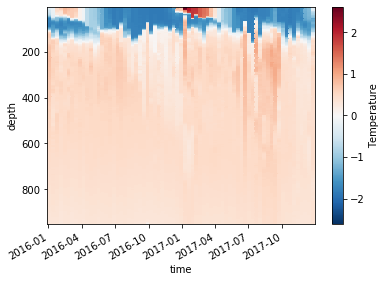

In [29]:
ds.plot()
plt.gca().invert_yaxis()